## Libraries

In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import glob
import sys
#import scvi
import gc
import re
import cytopus as cp
import Spectra
import gseapy as gp
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Site and health information

In [4]:
sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")
pheno_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/A6K/Phenotypes/Subject_Data.A6K.BRONZE.Phenotypes.2024_freeze_3.utf8.txt", sep="\t")
pheno_diab_raw = pd.read_csv("/project/tishkofflab/projects/danihar_biomarker_project/olink/data/phenotypes/v1/DF_step2.txt", sep="\t")

/tmp/ipykernel_28409/2595490462.py:1: DtypeWarning: Columns (4,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,130,131,132,133,134,135,136,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,185,187,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")
/tmp/ipykernel_28409/2595490462.py:2: DtypeWarning: Columns (4,5,6,10,12,73,74,108) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno_info_raw = pd

In [5]:
site_collect = sample_info_raw[['ID:topmed',
                                'ID:field',
                                'Subject_Information:Ethnicity::str',
                                'Collection_Information:Latitude::num::deg',
                                'Collection_Information:Longitude::num::deg',
                                'Collection_Information:Site::str',
                                'Collection_Information:Date::date',
                                'Categorization:Lifestyle:Subsistence_Practice::str',
                                'Categorization:Lifestyle:Subsistence_Practice:Notes::str']]

site_collect = site_collect.rename(columns={'ID:topmed': 'TID',
                                            'ID:field': 'FID',
                                            'Subject_Information:Ethnicity::str': 'Ethnicity',
                                            'Collection_Information:Latitude::num::deg': 'latitude',
                                            'Collection_Information:Longitude::num::deg': 'longitude',
                                            'Collection_Information:Site::str': 'site',
                                            'Collection_Information:Date::date': 'date',
                                            'Categorization:Lifestyle:Subsistence_Practice::str': 'subsistence'})

In [6]:
pheno = pheno_info_raw[['ID:topmed',
                        'Subject_Measurement:Cardiovascular:Blood_Pressure_Systolic:Mean::num::Hgmm',
                        'Subject_Measurement:Cardiovascular:Blood_Pressure_Diastolic:Mean::num::Hgmm',
                        'Subject_Measurement:Anthropometric:BMI::num',
                        'Subject_Measurement:Anthropometric:Body_Fat_Percentage::num::frac']] \
    .rename(columns={'ID:topmed': 'TID',
                     'Subject_Measurement:Cardiovascular:Blood_Pressure_Systolic:Mean::num::Hgmm': 'bp_systolic',
                     'Subject_Measurement:Cardiovascular:Blood_Pressure_Diastolic:Mean::num::Hgmm': 'bp_diastolic',
                     'Subject_Measurement:Anthropometric:BMI::num': 'BMI',
                     'Subject_Measurement:Anthropometric:Body_Fat_Percentage::num::frac': 'bf_pct'})

pheno = pheno_diab_raw[['ID:topmed',
                        'Biospecimen_Measurement:Blood:Glucose:Mean::num::mg/dL',
                        'Hypertension',
                        'Hypertension_bool',
                        'Diabetes',
                        'Subject_Information:Medical:Fasting:bool']] \
    .rename(columns={'ID:topmed': 'TID',
                     'Biospecimen_Measurement:Blood:Glucose:Mean::num::mg/dL': 'blood_glucose',
                     'Subject_Information:Medical:Fasting:bool': 'fasting_bool'}) \
    .merge(pheno, how="right")

## Functions

In [5]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [6]:
def grouped_obs_sum(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.sum(axis=0, dtype=np.float64))
    return out

## MISC

In [7]:
eth_map = {'BAKA': 'CHG',
           'BAKA - see Subject Notes': 'CHG',
           'BAGYELI': 'CHG',
           'MBORORO FULANI': 'Fulani',
           'TIKARI': 'Tikari'}

In [8]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00", "2015-08-06 00:00:00", "2015-08-07 00:00:00"]

## Adata

In [9]:
spectra_file = '../../test/test123/write/qc_020725.spectra_out.4k.h5ad'

In [10]:
adata = sc.read_h5ad(spectra_file, backed='r')

In [11]:
adata_umap = sc.read_h5ad("../../test/test123/write/qc_020725_wctypes.harmony.umap.h5ad", backed='r')
adata.obsm['X_umap'] = adata_umap[adata.obs_names].obsm['X_umap']

In [12]:
scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], 
                         index=adata.obs.index, 
                         columns=adata.uns['SPECTRA_overlap'].index)

In [13]:
adata.obs[adata.uns['SPECTRA_overlap'].index] = scores_df

In [10]:
adata_m = adata[adata.obs['cytopus_names']=="M"].to_memory()

In [77]:
frac_24 = adata_m.obs[adata_m.obs['COND']=="CTL"].groupby('FID')['24-X-M-X-M_IL17A_response'].apply(lambda x: np.mean(x>0.02)).to_frame().reset_index()

In [78]:
frac_24[['Ethnicity','SEX','AGE']] = frac_24.merge(adata_m.obs[['FID','Ethnicity','SEX','AGE']].drop_duplicates().reset_index().drop('index',axis=1))[['Ethnicity','SEX','AGE']]

In [79]:
frac_24[['TID','site','date']] = frac_24.reset_index().merge(site_collect[['FID','TID','site','date']]).set_index('index')[['TID','site','date']]

In [80]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00"]

In [81]:
frac_24['Sabga_June'] = pd.Series((frac_24['site']=="Sabga") & 
                                    (frac_24['date'].isin(contam_dates)), dtype='category')

In [82]:
pheno_cols = ['bp_systolic','bp_diastolic','Hypertension','Hypertension_bool','blood_glucose','Diabetes','BMI','bf_pct','fasting_bool']

In [83]:
frac_24[pheno_cols] = frac_24.reset_index().merge(pheno).set_index('index')[pheno_cols]

In [86]:
ht_table = frac_24[['Sabga_June','Hypertension']].value_counts().reset_index().pivot(index='Sabga_June', columns='Hypertension', values=0)
ht_table[ht_table.isna()] = 0

In [64]:
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

In [88]:
stats = importr('stats')
res = stats.fisher_test(np.array(ht_table))
print('p-value: {}'.format(res[0][0]))

p-value: 0.066154854600351


In [109]:
pop_foo = site_collect['Ethnicity'].value_counts().head(10).index

<Axes: xlabel='24-X-M-X-M_IL17A_response', ylabel='blood_glucose'>

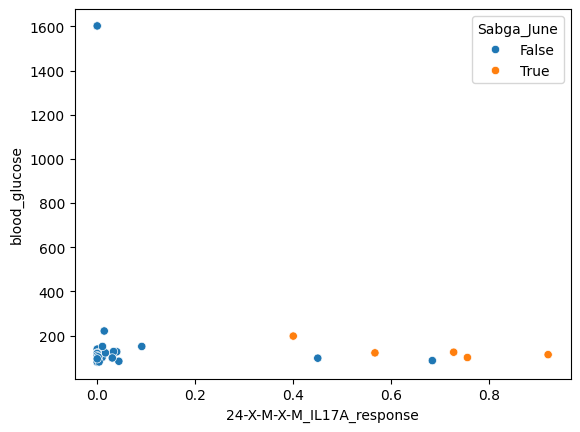

In [89]:
sns.scatterplot(frac_24, x='24-X-M-X-M_IL17A_response', y='blood_glucose', hue='Sabga_June')

<Axes: xlabel='AGE', ylabel='24-X-M-X-M_IL17A_response'>

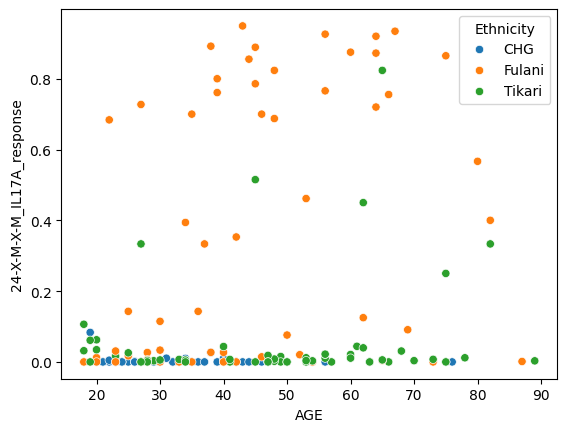

In [23]:
sns.scatterplot(frac_24, x='AGE', y='24-X-M-X-M_IL17A_response', hue='Ethnicity')

<Axes: xlabel='24-X-M-X-M_IL17A_response', ylabel='BMI'>

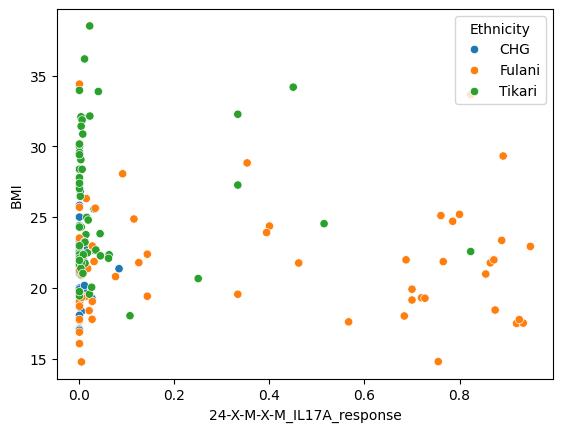

In [90]:
sns.scatterplot(frac_24, x='24-X-M-X-M_IL17A_response', y='BMI', hue='Ethnicity')

<Axes: xlabel='24-X-M-X-M_IL17A_response', ylabel='bp_systolic'>

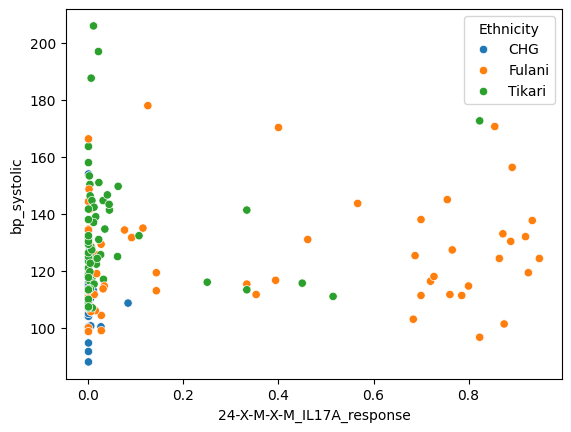

In [91]:
sns.scatterplot(frac_24, x='24-X-M-X-M_IL17A_response', y='bp_systolic', hue='Ethnicity')

<Axes: xlabel='24-X-M-X-M_IL17A_response', ylabel='bp_diastolic'>

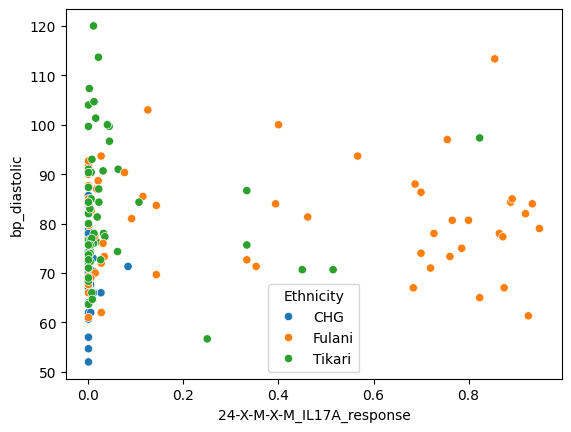

In [92]:
sns.scatterplot(frac_24, x='24-X-M-X-M_IL17A_response', y='bp_diastolic', hue='Ethnicity')

In [99]:
pheno

,TID,blood_glucose,Hypertension,Hypertension_bool,Diabetes,fasting_bool,bp_systolic,bp_diastolic,BMI,bf_pct
0,NWD263413,NaN,NaN,NaN,NaN,NaN,122.333333,80.333333,18.911628,NaN
1,NWD824993,NaN,NaN,NaN,NaN,NaN,150.833333,93.000000,21.793585,NaN
2,NWD532818,NaN,NaN,NaN,NaN,NaN,125.333333,84.666667,26.476280,NaN
3,NWD182194,NaN,NaN,NaN,NaN,NaN,105.166667,61.583333,22.922388,NaN
4,NWD116438,NaN,NaN,NaN,NaN,NaN,180.166667,100.000000,30.258605,NaN
...,...,...,...,...,...,...,...,...,...,...
10301,NA19983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10302,NA20128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10303,NA20129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10304,NA20279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


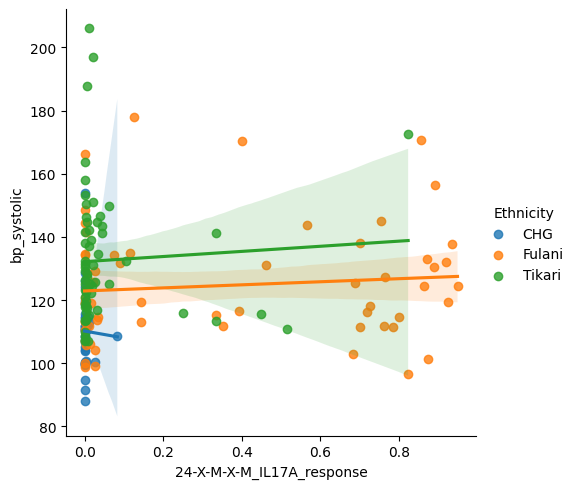

In [98]:
sns.lmplot(frac_24, x='24-X-M-X-M_IL17A_response', y='bp_systolic', hue='Ethnicity')

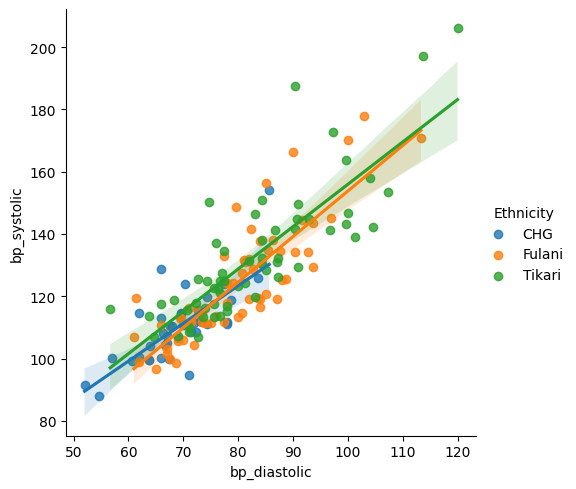

In [95]:
sns.lmplot(frac_24, x='bp_diastolic', y='bp_systolic', hue='Ethnicity')

<Axes: xlabel='24-X-M-X-M_IL17A_response', ylabel='bf_pct'>

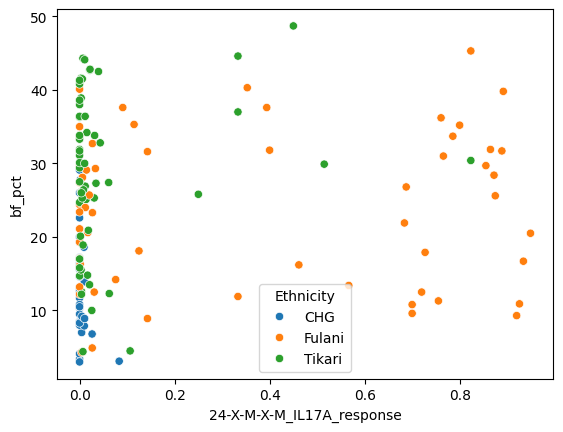

In [17]:
sns.scatterplot(frac_24, x='24-X-M-X-M_IL17A_response', y='bf_pct', hue='Ethnicity')

In [ ]:
plt.figure(figsize = (15,4))
ax = sns.boxplot(frac_24, x='date', y='24-X-M-X-M_IL17A_response', hue='Ethnicity')
plt.xticks(rotation=90)

In [28]:
ctype_counts = adata[adata.obs['COND']=="CTL"].obs.groupby('FID')['cytopus_names'] \
    .value_counts().to_frame().rename(columns={'cytopus_names': 'count'}) \
    .reset_index()

In [29]:
ctype_counts['frac'] = ctype_counts.groupby('FID')['count'].apply(lambda x: x/np.sum(x))

/tmp/ipykernel_140417/2790251048.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ctype_counts['frac'] = ctype_counts.groupby('FID')['count'].apply(lambda x: x/np.sum(x))


In [42]:
ctype_counts['sum'] = ctype_counts.groupby('FID')['count'].sum()

<Axes: xlabel='frac', ylabel='24-X-M-X-M_IL17A_response'>

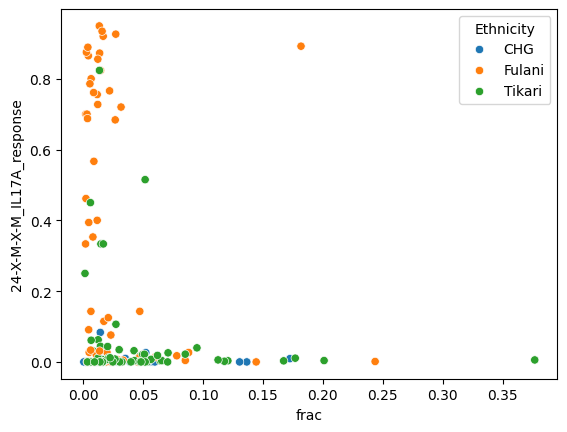

In [43]:
sns.scatterplot(frac_24.merge(ctype_counts[ctype_counts['cytopus_names']=="M"]), x='frac', y='24-X-M-X-M_IL17A_response', hue='Ethnicity')

<Axes: xlabel='count', ylabel='24-X-M-X-M_IL17A_response'>

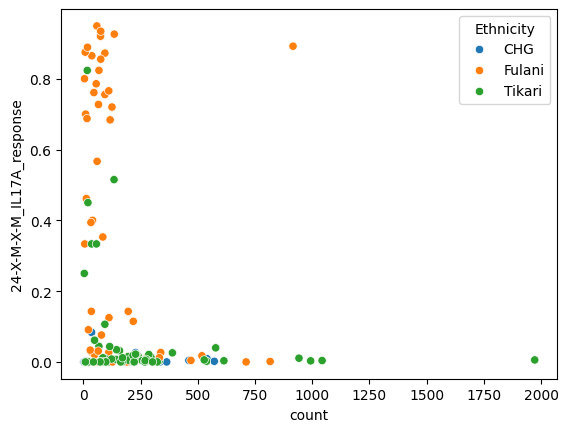

In [91]:
sns.scatterplot(frac_24.merge(ctype_counts[ctype_counts['cytopus_names']=="M"]), x='count', y='24-X-M-X-M_IL17A_response', hue='Ethnicity')

<Axes: xlabel='count', ylabel='24-X-M-X-M_IL17A_response'>

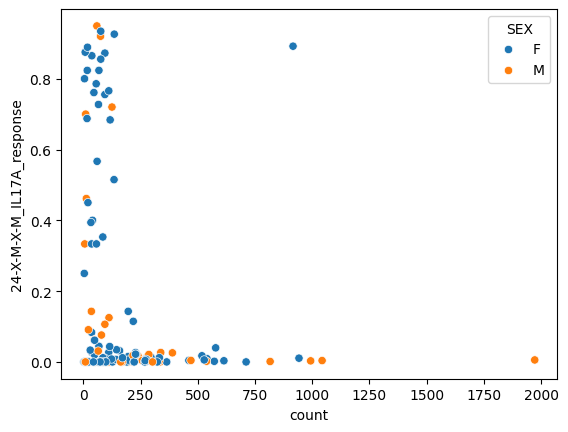

In [30]:
sns.scatterplot(frac_24.merge(ctype_counts[ctype_counts['cytopus_names']=="M"]), x='count', y='24-X-M-X-M_IL17A_response', hue='SEX')

In [115]:
ctype_counts['sum'] = ctype_counts.merge(ctype_counts.groupby('FID')['count'].sum().reset_index().rename(columns={'count':'sum'}))['sum']

<Axes: xlabel='sum', ylabel='BMI'>

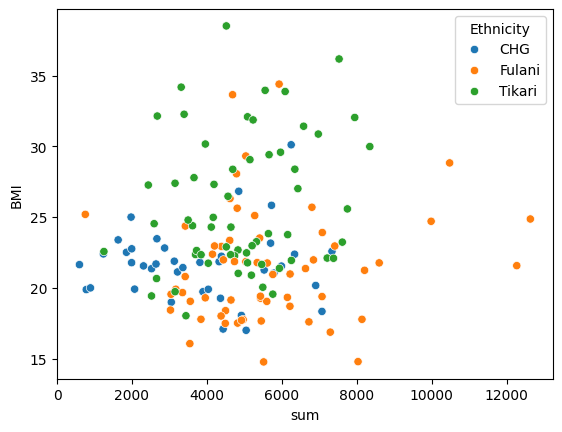

In [119]:
sns.scatterplot(frac_24.merge(ctype_counts[ctype_counts['cytopus_names']=="M"]), x='sum', y='BMI', hue='Ethnicity')

In [54]:
pcs = pd.read_csv("../eqtl/data/cameroon_samples.030425.pcs.csv", index_col=0)

In [55]:
pcs_pop = pcs.reset_index().rename(columns={'index': 'TID'}).merge(adata.obs[['TID','Ethnicity']].drop_duplicates()).merge(site_collect[['TID','site','date']])

In [56]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00"]

In [57]:
pcs_pop['Sabga_June'] = pd.Series((pcs_pop['site']=="Sabga") & 
                                  (pcs_pop['date'].isin(contam_dates)), dtype='category')

<Axes: xlabel='PC1', ylabel='PC2'>

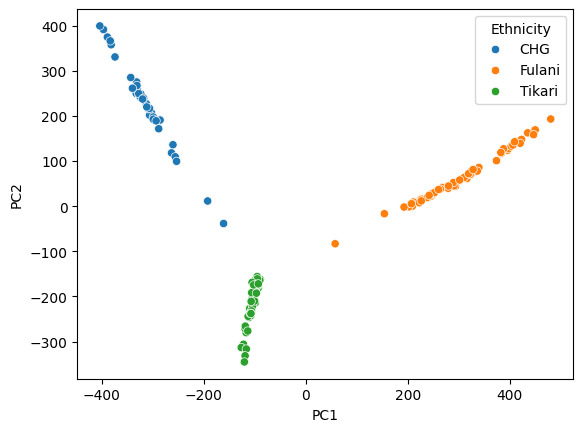

In [58]:
sns.scatterplot(pcs_pop, x="PC1", y="PC2", hue="Ethnicity")

In [59]:
pcs_pop['24-X-M-X-M_IL17A_response'] = pcs_pop[['TID']].merge(frac_24[['TID','24-X-M-X-M_IL17A_response']])['24-X-M-X-M_IL17A_response']

<Axes: xlabel='PC1', ylabel='PC2'>

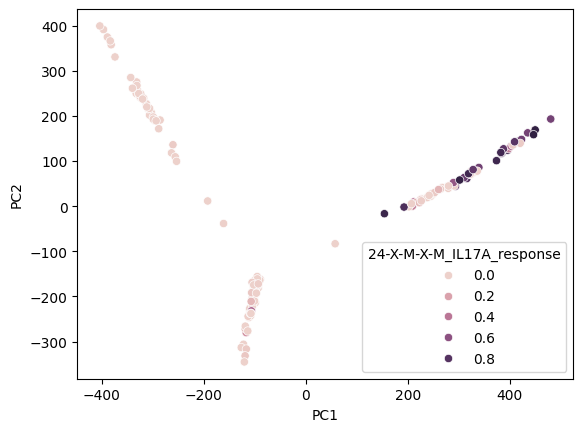

In [61]:
sns.scatterplot(pcs_pop, x="PC1", y="PC2", hue="24-X-M-X-M_IL17A_response")

<Axes: xlabel='PC1', ylabel='24-X-M-X-M_IL17A_response'>

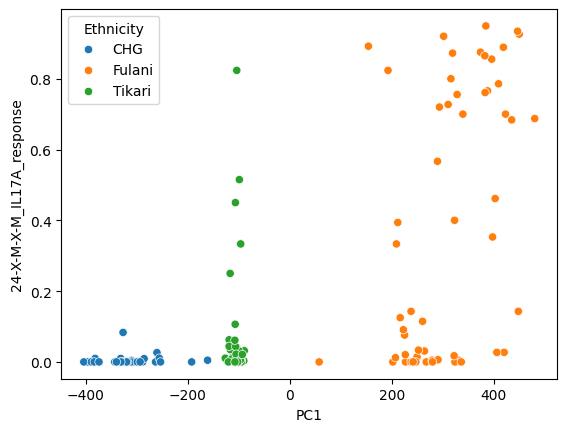

In [62]:
sns.scatterplot(pcs_pop, x="PC1", y="24-X-M-X-M_IL17A_response", hue="Ethnicity")

In [18]:
frac_24_all = adata_m.obs.groupby(['COND','FID'])['24-X-M-X-M_IL17A_response'].apply(lambda x: np.mean(x>0.02)).to_frame().reset_index()

In [19]:
frac_24_all[['Ethnicity','SEX','AGE']] = frac_24_all.merge(adata_m.obs[['FID','Ethnicity','SEX','AGE']].drop_duplicates().reset_index().drop('index',axis=1))[['Ethnicity','SEX','AGE']]

In [45]:
frac_24_all_wide = frac_24_all.pivot(index='FID', columns='COND', values='24-X-M-X-M_IL17A_response').reset_index()

In [52]:
frac_24_all_wide = frac_24_all_wide.merge(adata.obs[['FID','Ethnicity']].drop_duplicates())

<Axes: xlabel='CTL', ylabel='IFN'>

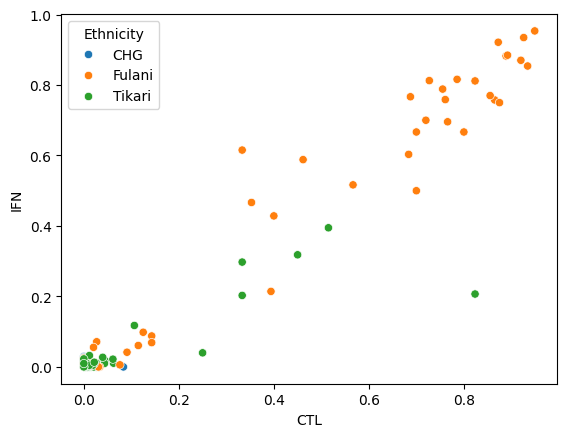

In [53]:
sns.scatterplot(frac_24_all_wide, x='CTL', y='IFN', hue='Ethnicity')

<Axes: xlabel='CTL', ylabel='LPS'>

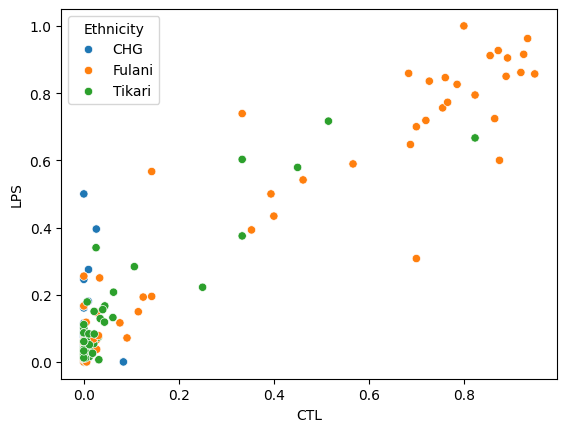

In [54]:
sns.scatterplot(frac_24_all_wide, x='CTL', y='LPS', hue='Ethnicity')

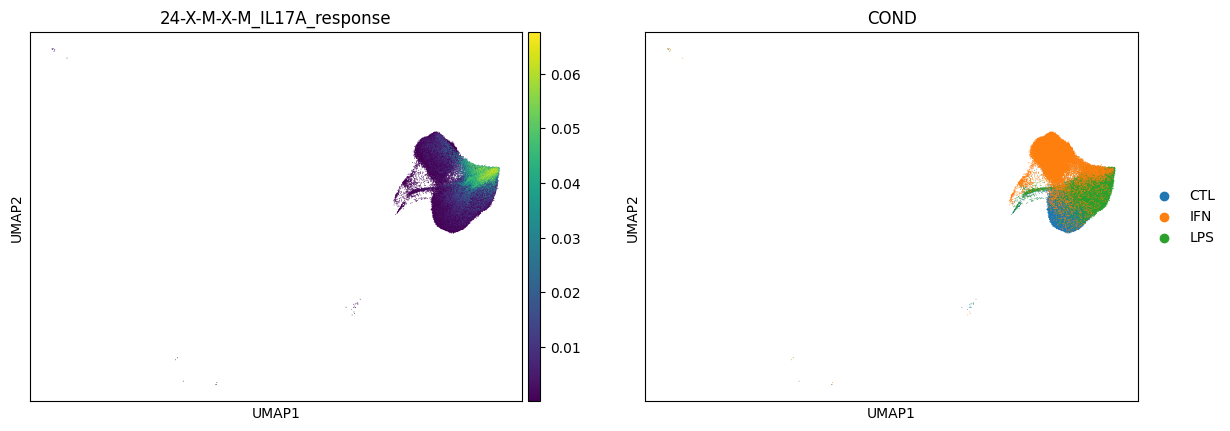

In [61]:
sc.pl.umap(adata_m, color=['24-X-M-X-M_IL17A_response','COND'])

## Whole blood bulk RNA-seq

In [14]:
gtf = pd.read_csv("/project/tishkofflab/data_public/reference/gencode.v32.chr_patch_hapl_scaff.basic.annotation.gtf.gz", 
                  comment="#", header=None, sep='\t', names=['chr','src','type','start','end','foo','strand','bar','info'])

In [15]:
gene_map = gtf[gtf['type']=="gene"]['info'].str.extract(r'gene_id \"(?P<gene_id>ENSG\d+\.\d+)\".*gene_name \"(?P<gene_name>.*?)\"')

In [16]:
tpm = pd.read_csv("/project/tishkofflab/people/chaozhang/share/derek/genes.tpm.all.rnaseqc.csv", sep="\t")

In [17]:
tpm_df = tpm.merge(gene_map, left_on="feature", right_on="gene_id").set_index('gene_name').drop(['feature','gene_id'], axis=1).transpose()

In [18]:
samps = np.unique(adata.obs['FID'])
tpm_samps = tpm_df.index[pd.Series(tpm_df.index).isin(samps)]
cam_samps = site_collect[site_collect['Ethnicity'].isin(['MBORORO FULANI','BAGYELI','BAKA','TIKARI','BAKA - see Subject Notes'])]['FID']
tpm_cam = tpm_df.index[pd.Series(tpm_df.index).isin(cam_samps)]

In [19]:
markers_24 = list(adata.var_names[adata.var['spectra_vocab']][np.argsort(-adata.uns['SPECTRA_factors'][24,:])][0:500])

In [20]:
#tpm_24 = tpm_df.loc[tpm_samps, adata.uns['SPECTRA_markers'][24]]
tpm_24 = tpm_df.loc[tpm_cam, markers_24]
tpm_24 = tpm_24.loc[:,tpm_24.apply(sum)>0]

### PCA

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(tpm_24)

In [20]:
pca = PCA(n_components=2) # Retain 2 principal components
pca.fit(scaled_data)

PCA(n_components=2)

In [21]:
transformed_data = pca.transform(scaled_data)

In [33]:
pc_df = pd.DataFrame({'PC1': transformed_data[:,0], 
                      'PC2': transformed_data[:,1]}, 
                     index=tpm_samps).reset_index().rename(columns={'index': 'FID'}) \
    .merge(site_collect[['FID','Ethnicity','site','date']])

In [34]:
eth_map = {'BAKA': 'CHG',
           'BAKA - see Subject Notes': 'CHG',
           'BAGYELI': 'CHG',
           'MBORORO FULANI': 'Fulani',
           'TIKARI': 'Tikari'}

In [37]:
pc_df['Ethnicity'] = pd.Series(pc_df['Ethnicity'].apply(lambda x: eth_map[x]), dtype="category")\
    .cat.reorder_categories(new_categories=['Tikari','Fulani','CHG'])

In [35]:
pc_df['pcontam'] = pd.Series((pc_df['site']=="Sabga") & pc_df['date'].isin(contam_dates), dtype="category")

<Axes: xlabel='PC1', ylabel='PC2'>

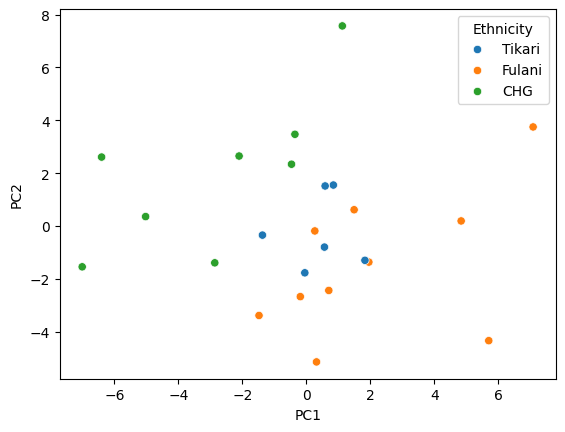

In [38]:
sns.scatterplot(pc_df, x="PC1", y="PC2", hue='Ethnicity')

<Axes: xlabel='PC1', ylabel='PC2'>

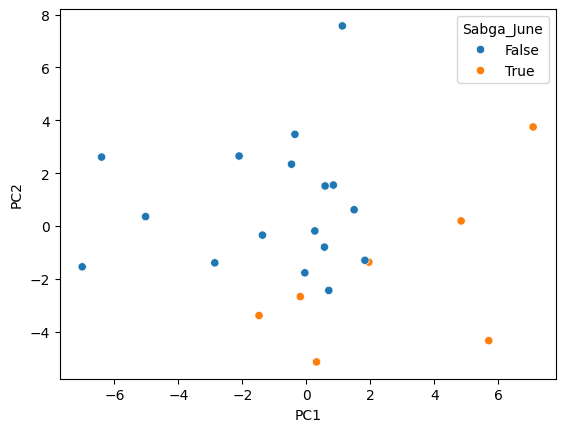

In [40]:
sns.scatterplot(pc_df, x="PC1", y="PC2", hue='Sabga_June')

In [314]:
pc_df['Fulani'] = pd.Series(pc_df['Ethnicity']=="MBORORO FULANI", dtype='category')
pc_df['Hadza'] = pd.Series(pc_df['Ethnicity']=="HADZABE", dtype='category')

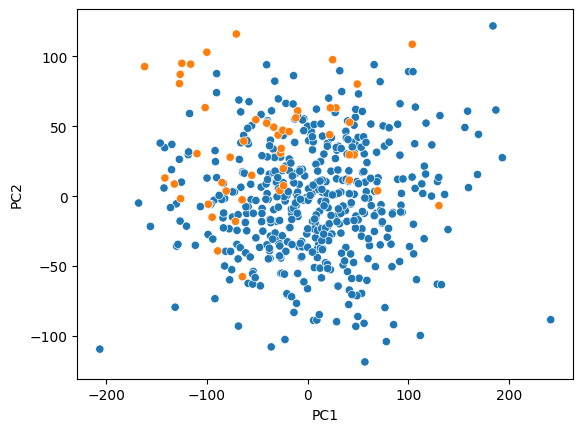

In [284]:
sns.scatterplot(pc_df, x="PC1", y="PC2", hue='Fulani')
plt.legend([],[], frameon=False)

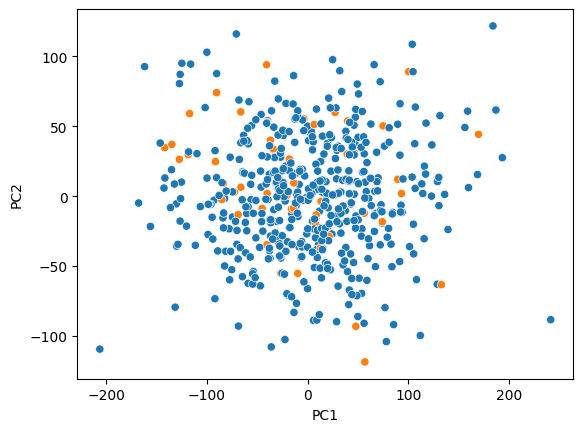

In [315]:
sns.scatterplot(pc_df, x="PC1", y="PC2", hue='Hadza')
plt.legend([],[], frameon=False)

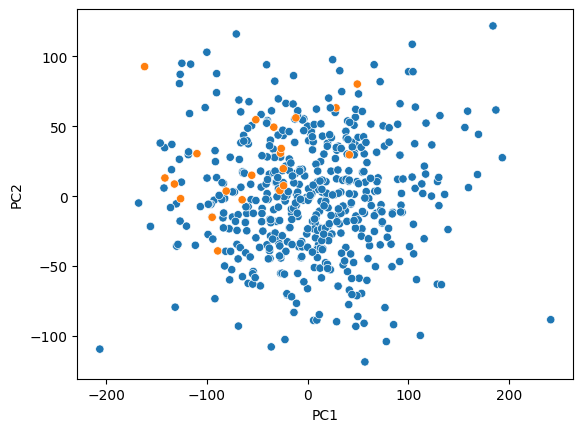

In [286]:
sns.scatterplot(pc_df, x="PC1", y="PC2", hue='Sabga_June')
plt.legend([],[], frameon=False)

In [220]:
adata.uns['SPECTRA_markers'][24][np.argsort(pca.components_[0,:])]

array(['MT1G', 'MT1F', 'SERPINB2', 'SLC7A11', 'MT1E', 'SOX5', 'MT1H',
       'MT1M', 'MET', 'FCER1G', 'ABCA1', 'PLAUR', 'S100A8', 'TNFAIP6',
       'CTSL', 'CCL4', 'S100A9', 'KYNU', 'AC025580.2', 'IL24', 'C15orf48',
       'CCL3', 'ANPEP', 'IL1A', 'IL1B', 'MMP14', 'HCK', 'CCL3L1', 'SNX9',
       'EREG', 'EPB41L3', 'NAMPT', 'DOCK4', 'CXCL5', 'GLIS3', 'THBS1',
       'CXCL2', 'ITGB8', 'PID1', 'IER3', 'CXCL1', 'CXCL3', 'CXCL8',
       'MARCKS', 'TLR2', 'CD14', 'SLC25A37', 'SOD2', 'PTGS2', 'PILRA'],
      dtype=object)

In [221]:
adata.uns['SPECTRA_markers'][24][np.argsort(pca.components_[1,:])]

array(['SNX9', 'EPB41L3', 'MMP14', 'CXCL2', 'CXCL3', 'CCL4', 'C15orf48',
       'ITGB8', 'KYNU', 'THBS1', 'IL24', 'EREG', 'CD14', 'CTSL', 'PID1',
       'MET', 'MT1H', 'AC025580.2', 'MT1E', 'IER3', 'CCL3', 'CXCL5',
       'MT1F', 'MT1M', 'IL1A', 'CXCL8', 'SOX5', 'SLC7A11', 'TLR2',
       'MARCKS', 'ABCA1', 'MT1G', 'DOCK4', 'GLIS3', 'PILRA', 'FCER1G',
       'CCL3L1', 'PTGS2', 'TNFAIP6', 'SLC25A37', 'SOD2', 'HCK', 'PLAUR',
       'SERPINB2', 'CXCL1', 'ANPEP', 'IL1B', 'NAMPT', 'S100A8', 'S100A9'],
      dtype=object)

### NMF

In [22]:
eth_map = {'BAKA': 'CHG',
           'BAKA - see Subject Notes': 'CHG',
           'BAGYELI': 'CHG',
           'MBORORO FULANI': 'Fulani',
           'TIKARI': 'Tikari'}

In [23]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00", "2015-08-06 00:00:00", "2015-08-07 00:00:00"]

In [24]:
def format_plot_df(ndarray, index, cols):
    df = pd.DataFrame(ndarray, index=tpm_24_norm.index, columns=cols) \
        .reset_index().rename(columns={'index': 'FID'}) \
        .merge(site_collect[['FID','Ethnicity','site','date']])

    df['Ethnicity'] = pd.Series(df['Ethnicity'].apply(lambda x: eth_map[x]), dtype="category")\
        .cat.reorder_categories(new_categories=['Tikari','Fulani','CHG'])

    df['pcontam'] = pd.Series(df['date'].isin(contam_dates), dtype="category")

    return(df)

In [25]:
from sklearn.decomposition import NMF

In [26]:
tpm_24_norm = tpm_24/tpm_24.apply(max, axis=0)
tpm_24_log = np.log2(tpm_24+1)

In [27]:
model = NMF(n_components=2, init='random', random_state=4690)
W = model.fit_transform(tpm_24_norm)
H = model.components_

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [28]:
W_norm = format_plot_df(W, index=tpm_24_norm.index, cols=["W" + str(x) for x in range(1,3)])

<Axes: xlabel='W1', ylabel='W2'>

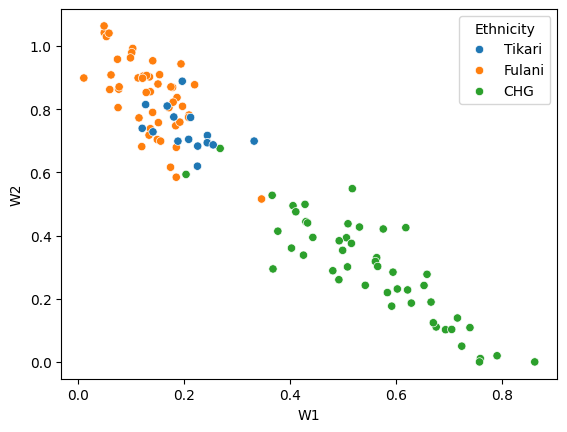

In [29]:
sns.scatterplot(W_norm, x="W1", y="W2", hue='Ethnicity')

<Axes: xlabel='W1', ylabel='W2'>

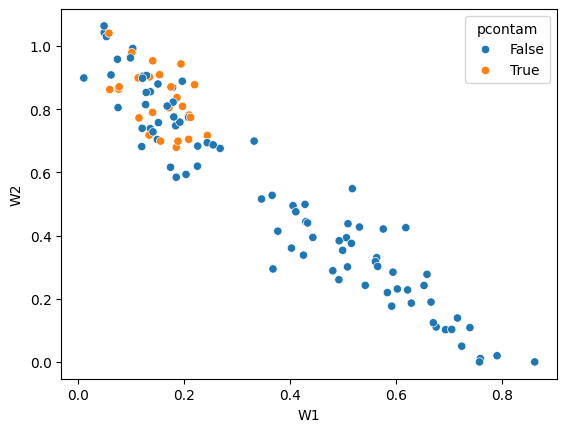

In [30]:
sns.scatterplot(W_norm, x="W1", y="W2", hue='pcontam')

Log-transformed data

In [31]:
W = model.fit_transform(tpm_24_log)
H = model.components_

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [32]:
W_log = format_plot_df(W, index=tpm_24_norm.index, cols=["W1","W2"])

<Axes: xlabel='W1', ylabel='W2'>

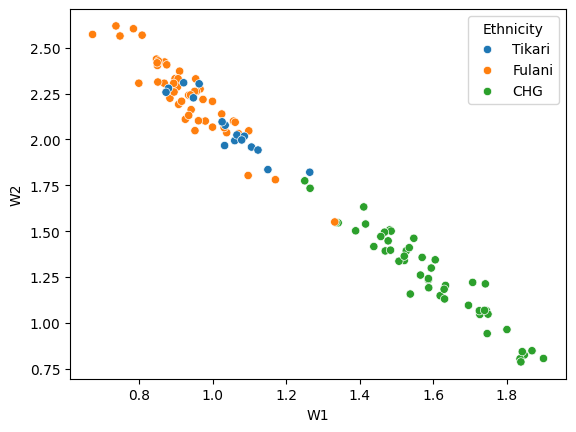

In [34]:
sns.scatterplot(W_log, x="W1", y="W2", hue='Ethnicity')

<Axes: xlabel='W1', ylabel='W2'>

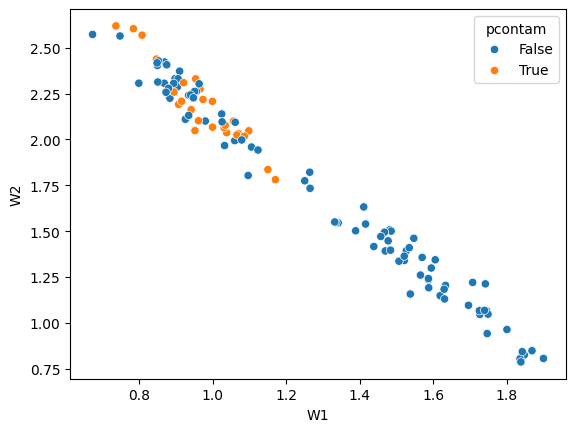

In [35]:
sns.scatterplot(W_log, x="W1", y="W2", hue='pcontam')

<Axes: >

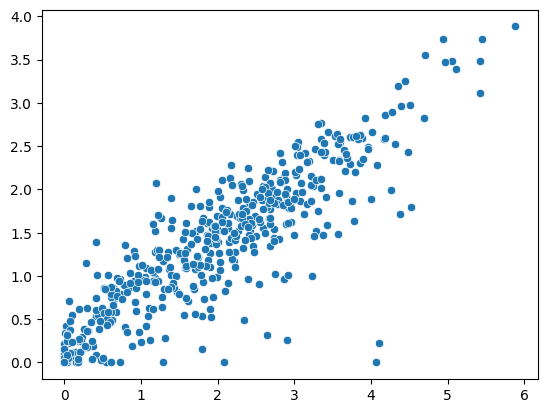

In [36]:
sns.scatterplot(x=H[0,:], y=H[1,:])

In [239]:
H[0,:][-np.argsort(H[0,:]]

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2746231429.py, line 1)

In [38]:
tpm_24_log.columns[np.argsort(-H[1,:])]

Index(['S100A9', 'MT-CO3', 'MT-ATP6', 'LYZ', 'FTL', 'MT-CYB', 'MT-ND3',
       'S100A8', 'FTH1', 'PSAP',
       ...
       'SERPINB2', 'IDO1', 'LINC02376', 'AKR1C1', 'IL19', 'SOX5', 'ADAMDEC1',
       'CCL2', 'MT1M', 'MT1H'],
      dtype='object', name='gene_name', length=495)

In [39]:
pop_cols = {'CHG': '#60B944',
            'Fulani': '#DD6060',
            'Tikari': '#538AE5'
           }

In [44]:
tpm_24_clust = (tpm_24_log - tpm_24_log.apply('mean')) / tpm_24_log.apply('std')

In [45]:
tpm_24_clust = tpm_24_clust.iloc[np.argsort(W[:,0]),:]

In [46]:
tpm_24_clust = tpm_24_clust.reset_index().rename(columns={'index': 'FID'}).merge(W_norm[['FID','Ethnicity']]).sort_values('Ethnicity')

In [47]:
pop_cols = tpm_24_clust['Ethnicity'].apply(lambda x: pop_cols[x])

/home/derkelly/miniconda3/envs/ctypist/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


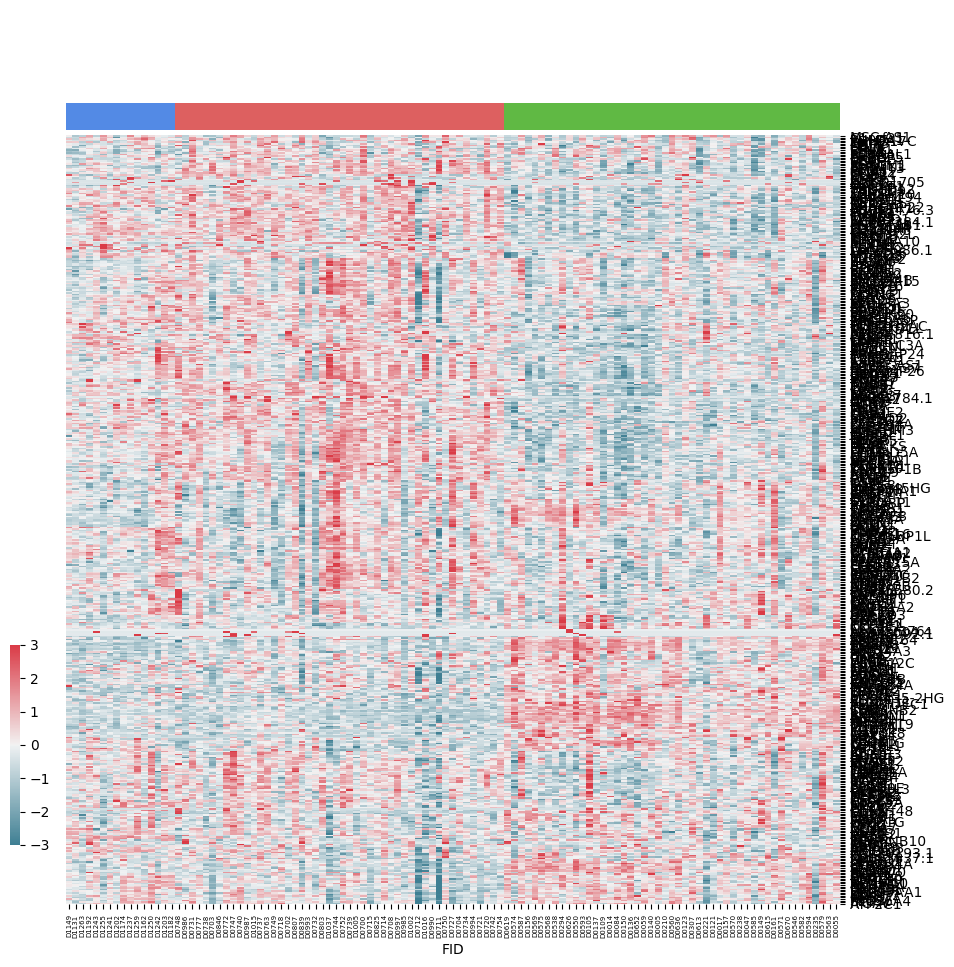

In [59]:
markers = adata.var_names[adata.var['spectra_vocab']][np.argsort(-adata.uns['SPECTRA_factors'][24,:])][0:500]
markers = list(set(tpm_24_log.columns).intersection(markers))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cg = sns.clustermap(tpm_24_clust.set_index('FID')[markers].transpose(),
                    method ='complete', cmap=cmap,
                    center=0, yticklabels=1, xticklabels=1, z_score=None,
                    row_cluster=True, col_cluster=False, vmin=-3, vmax=3, cbar_pos=(.05, .15, .01, .2),
                    dendrogram_ratio=0.1, colors_ratio=(0.005, 0.03),
                    col_colors=[pop_cols])
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, size=5)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), size=10)
cg.ax_row_dendrogram.set_visible(False)

## CTL-specific factors

In [9]:
adata = sc.read_h5ad("output/qc_020725.spectra_out.CTL.10k.h5ad")

In [10]:
adata

AnnData object with n_obs × n_vars = 791376 × 36601
    obs: 'donor_id', 'library', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'doublet_score', 'predicted_doublet', 'FID', 'LID', 'TID', 'COHORT', 'COND', 'SEX', 'AGE', 'POP', 'Ethnicity', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'cytopus_names'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'spectra_vocab'
    uns: 'SPECTRA_L', 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_overlap', 'hvg', 'log1p'
    obsm: 'SPECTRA_cell_scores'

## Correlate Pseudo-Bulk

In [42]:
adata_c = adata[adata.obs['COND']=="CTL"].to_memory()

In [58]:
pseudo_cnts = grouped_obs_sum(adata_c, 'FID')

In [59]:
samp_mils = pseudo_cnts.apply(sum, axis=0)/1e6

In [ ]:
pseudo_cnts


KeyboardInterrupt



In [127]:
pseudo_24 = (pseudo_cnts.loc[adata.uns['SPECTRA_markers'][24],:]/samp_mils).transpose().reset_index().rename(columns={'index': 'FID'})

In [128]:
pseudo_24l = pd.melt(pseudo_24, id_vars='FID', value_vars=adata.uns['SPECTRA_markers'][24], var_name='gene', value_name='tpm_pseudo')

In [115]:
tpm_24l = pd.melt(tpm_24.reset_index().rename(columns={'index': 'FID'}), id_vars='FID', value_vars=adata.uns['SPECTRA_markers'][24], var_name='gene', value_name='tpm')

In [131]:
pseudo_tpm_24l = tpm_24l.merge(pseudo_24l)

In [136]:
np.unique(pseudo_tpm_24l['gene'])

array(['ABCA1', 'AC025580.2', 'ANPEP', 'C15orf48', 'CCL3', 'CCL3L1',
       'CCL4', 'CD14', 'CTSL', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5',
       'CXCL8', 'DOCK4', 'EPB41L3', 'EREG', 'FCER1G', 'GLIS3', 'HCK',
       'IER3', 'IL1A', 'IL1B', 'IL24', 'ITGB8', 'KYNU', 'MARCKS', 'MET',
       'MMP14', 'MT1E', 'MT1F', 'MT1G', 'MT1H', 'MT1M', 'NAMPT', 'PID1',
       'PILRA', 'PLAUR', 'PTGS2', 'S100A8', 'S100A9', 'SERPINB2',
       'SLC25A37', 'SLC7A11', 'SNX9', 'SOD2', 'SOX5', 'THBS1', 'TLR2',
       'TNFAIP6'], dtype=object)

<Axes: xlabel='tpm', ylabel='tpm_pseudo'>

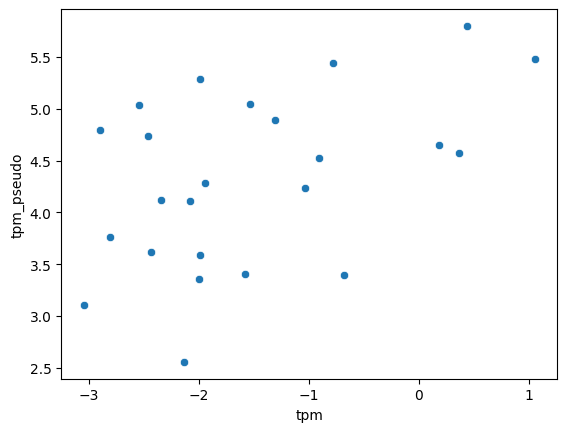

In [148]:
sns.scatterplot(x=np.log2(pseudo_tpm_24l[pseudo_tpm_24l['gene']=="SOX5"]['tpm']), y=np.log2(pseudo_tpm_24l[pseudo_tpm_24l['gene']=="SOX5"]['tpm_pseudo']))